In [208]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import matplotlib 
from PIL import Image
import PIL
import math
from random import random
from random import seed
from random import randint
import time
from numba import jit,njit,prange
from scipy import ndimage, misc
import scipy.stats as stats
from scipy.fftpack import fft2, ifft2 
from mpl_toolkits.mplot3d import Axes3D
import cv2

In [304]:
# comoving but the strings stay put (ideal for radiation or matter)

@jit(nopython = True)
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h))
    result = np.zeros((h,h))
    
    for i in range(0, h):
        for j in range(0,h):
            P[i,j] = (-A[(i+2)%h,j] + 16*A[(i+1)%h,j] + 16*A[(i-1)%h,j] -A[(i-2)%h,j] \
                 -A[i,(j+2)%h] + 16*A[i,(j+1)%h]  + 16*A[i,(j-1)%h] -A[i,(j-2)%h] - 60*A[i,j])/(12*pow(deltax,2))

  
    return P 

@njit(parallel=True)
def Laplacian_parallel(A,deltax,deltat):
    h = len(A)
    P = np.zeros((h,h))
    for i in prange(0,h):
        for j in prange(0,h):
            P[i,j] = (-A[(i+2)%h,j] + 16*A[(i+1)%h,j] + 16*A[(i-1)%h,j] -A[(i-2)%h,j] \
                 -A[i,(j+2)%h] + 16*A[i,(j+1)%h]  + 16*A[i,(j-1)%h] -A[i,(j-2)%h] - 60*A[i,j])/(12*pow(deltax,2))

  
    return P 



def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):
    H_0 = 2.18e-18
    #a = np.sqrt(2*H_0)*np.sqrt(time)
    #a = H_0 ** (2/3) * time ** (2/3)
    a = 4.36000000000006e-18 * time - 6.78288102293483e-23 
    beta = 0
    alpha = 3
    era = 1 #radiation
    #era = 2 #matter
    

    lam = 2*pow(math.pi,2)/pow(omega,2)
    

    
    F1 = Laplacian(A1,deltax,deltat) - a**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel1*1/time
    F2 = Laplacian(A2,deltax,deltat) - a**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel2*1/time
    
    time = time + deltat
    
    a1 = 4.36000000000006e-18 * time - 6.78288102293483e-23 
    
    

    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 

    
    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a1**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) \
                                   -alpha*era*vel1*1/time)
    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a1**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) \
                                  -alpha*era*vel2*1/time)
    
    
    return A1,A2,vel1,vel2,a,time
    
#change the values accordlingly    
def wolff(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):
    fig = plt.figure(figsize=(8,8))
    fig.set_facecolor('white')
    plt.xlim([1e-3, 1.5])
    plt.ylim([1e3,1e9])
    
    con = []
    
    THRESHOLD = 55
    
    time = t0
    a = 0

    vel1 = vel
    vel2 = vel
    
    fs = deltax
    
    freq_shifted = fs/2*np.linspace(-1,1,N)
    freq = fs/2 * np.linspace(0,1,int(N/2))

    kfreq = np.fft.fftfreq(N)*N
    
    kx,ky = np.meshgrid(kfreq,kfreq)
    
    knrm = np.sqrt(kx**2 + ky**2)
    knrm = knrm.flatten()
    
    kbins = np.arange(0.5,N//2 + 1,1)

    kvals = 0.5*(kbins[1:]+kbins[:-1])
    
    x = np.arange(A1.shape[0])
    y = np.arange(A1.shape[1])
    X,Y = np.meshgrid(x,y)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    black = [0,0,0]     #---Color of the border--- not actually black
    B = []

    for i in np.arange(int(t/deltat)):
        time = round(time,3)
        
        if time % 1 == 0:

                
            plt.imsave('112/'+str(int(time)).zfill(3)+'.png',np.sqrt(pow(A1,2)+pow(A2,2)),vmin = 0, vmax = eta,cmap = 'Greys')
            #plt.imsave('311/'+str(int(time)).zfill(3)+'.png',np.arctan2(A2,A1),vmin = -1*math.pi, vmax = math.pi,cmap = 'twilight')
            

            im = cv2.imread('112/'+str(int(time)).zfill(3)+'.png')

            imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    
            ret, thresh = cv2.threshold(imgray, THRESHOLD, 255, 0)
            contours, hierarchy = cv2.findContours(cv2.bitwise_not(thresh), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
       
            
            
            
  
            
            B.append(cv2.drawContours(im, contours, -1, (0, 255, 0), 3))
            constant=cv2.copyMakeBorder(B[int(time-1)],10,10,10,10,cv2.BORDER_CONSTANT,value=black )
     
                
                
            violet= np.zeros((100, constant.shape[1], 3), np.uint8)
            violet[:] = (255, 0, 180) 
            vcat = cv2.vconcat((violet, constant))
            
            B[int(time-1)] = cv2.putText(vcat,str(len(contours)),(30,50), font, 2,(0,0,0), 3, 0)
            cv2.imwrite('316/'+str(int(time)).zfill(3)+'.png',B[int(time-1)])
            
            
#             if time == 5:

#                 f_image = np.fft.fftn(mod)

#                 f_images = np.abs(f_image)**2
#                 f_images = f_images.flatten()

#                 Abins,_,_ = stats.binned_statistic(knrm,f_images,statistic = 'mean',bins = kbins)
#                 Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

#                 im = plt.loglog(fs/kvals,Abins,color='black')

#                 plt.savefig('315/'+str(int(time/5)).zfill(3)+'.png', bbox_inches= 'tight')

#                 im = im.pop(0)

#                 im.remove()

      
      
            
            
            
        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2

128


2560.0


KeyboardInterrupt: 

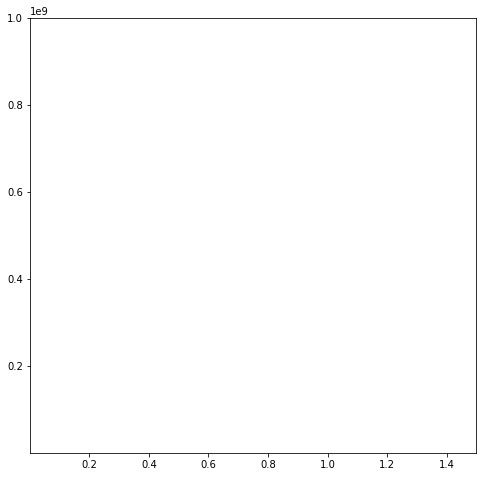

In [303]:
start = time.time()
plt.close()

n = 9
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time

vel = np.zeros((N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N, N))
A2 = np.random.normal(mu,sigma,size=(N,N))

A1,A2 = wolff(N,t0,t5,A1,A2,vel,omega,eta,deltax,deltat)

end = time.time()

print(end - start)

In [3]:
Laplacian(np.zeros((10,10)),1,0.1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
    #ax = Axes3D(fig)
    #ax.set_zlim3d(-10, 5)
    #plt.xlim([1e-2, 1.5])
    #plt.ylim([1e1,1e7])

#surf = ax.plot_surface(kx,ky,np.log(np.abs(f_image)**2),cmap='viridis')
            

            #plt.savefig('314/'+str(int(time)).zfill(3)+'.png', bbox_inches= 'tight')
        
                    #surf.remove()


In [25]:
# comoving but the strings stay put (non-ideal)

@jit(nopython = True)
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h))
    result = np.zeros((h,h))
    
    for i in range(0, h):
        for j in range(0,h):
            P[i,j] = (-A[(i+2)%h,j] + 16*A[(i+1)%h,j] + 16*A[(i-1)%h,j] -A[(i-2)%h,j] \
                 -A[i,(j+2)%h] + 16*A[i,(j+1)%h]  + 16*A[i,(j-1)%h] -A[i,(j-2)%h] - 60*A[i,j])/(12*pow(deltax,2))

  
    return P 



def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):
    H_0 = 2.18e-18
    c_1 = 0.822
    c_2 = 0.0623
    c_3 = 0.645

    a1 = 2.93282351932618e-37 * time **2
    beta = 0
    alpha = 3
    ln_da_dt = 2
    
    lam = 2*pow(math.pi,2)/pow(omega,2)
    

    
    F1 = Laplacian(A1,deltax,deltat) - a1**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*ln_da_dt*vel1*1/time
    F2 = Laplacian(A2,deltax,deltat) - a1**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*ln_da_dt*vel2*1/time
    
    time = time + deltat
    
    a2 = 2.93282351932618e-37 * time **2
    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 

    
    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a2**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*ln_da_dt*vel1*1/time) 
    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a2**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*ln_da_dt*vel2*1/time)
    
    
    return A1,A2,vel1,vel2,a1,time
    
#change the values accordlingly    
def wolff(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):
   
    H_0 = 2.18e-18
    time = t0

    vel1 = vel
    vel2 = vel
    
    c_1 = 0.822
    c_2 = 0.0623
    c_3 = 0.645
    a = c_1 * (time*H_0) ** (2/3) + c_2*(np.exp((time*H_0)/c_3)-1)

    

    for i in np.arange(int(t/deltat)):
        time = round(time,3)
        
        if time % 1 == 0:

            plt.imsave('313/'+str(int(time)).zfill(3)+'.png',np.arctan2(A2,A1),vmin = -1*math.pi, vmax = math.pi,cmap = 'twilight')
             

            
        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2

In [26]:
start = time.time()
plt.close()

n = 10
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time

vel = np.zeros((N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N, N))
A2 = np.random.normal(mu,sigma,size=(N,N))

A1,A2 = wolff(N,t0,t5,A1,A2,vel,omega,eta,deltax,deltat)

end = time.time()
print(end - start)

5120.0
2405.4345285892487


In [22]:
@jit(nopython = True)
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h))
    result = np.zeros((h,h))
    
    for i in range(0, h):
        for j in range(0,h):
            P[i,j] = (-A[(i+2)%h,j] + 16*A[(i+1)%h,j] + 16*A[(i-1)%h,j] -A[(i-2)%h,j] \
                 -A[i,(j+2)%h] + 16*A[i,(j+1)%h]  + 16*A[i,(j-1)%h] -A[i,(j-2)%h] - 60*A[i,j])/(12*pow(deltax,2))

  
    return P 



def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):
    H_0 = 2.18e-18
    #a = np.sqrt(2*H_0)*np.sqrt(time)
    a = 4.75240000000367e-36 * time**2
    beta = 0
    alpha = 3
    #era = 1 #radiation
    era = 2 #matter

    lam = 2*pow(math.pi,2)/pow(omega,2)
    

    
    F1 = Laplacian(A1,deltax,deltat) - a**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel1*1/time
    F2 = Laplacian(A2,deltax,deltat) - a**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel2*1/time
    
    time = time + deltat
    
    a1 = 4.75240000000367e-36 * time**2

    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 

    
    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a1**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel1*1/time) 
    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a1**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel2*1/time)
    
    
    return A1,A2,vel1,vel2,a,time
    
#change the values accordlingly    
def wolff(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):

    time = t0
    a = 0

    vel1 = vel
    vel2 = vel


    for i in np.arange(int(t/deltat)):
        time = round(time,3)
        
        if time % 1 == 0:

        
            #plt.imsave('113/'+str(int(time)).zfill(3)+'.png',np.sqrt(pow(A1,2)+pow(A2,2)),vmin = 0, vmax = eta,cmap = 'Greys')
            plt.imsave('312/'+str(int(time)).zfill(3)+'.png',np.arctan2(A2,A1),vmin = -1*math.pi, vmax = math.pi,cmap = 'twilight')

        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2

In [23]:
start = time.time()
plt.close()

n = 10
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time

vel = np.zeros((N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N, N))
A2 = np.random.normal(mu,sigma,size=(N,N))

A1,A2 = wolff(N,t0,t5,A1,A2,vel,omega,eta,deltax,deltat)

end = time.time()
print(end - start)

5120.0
2197.206091403961


In [176]:
from numpy import random

N = 1024
A = np.cos(2*np.pi*np.random.uniform(size = (N,N)))

%timeit Laplacian(A,1,0.1)
%timeit Laplacian_parallel(A,1,0.1)

22.3 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.8 ms ± 411 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
